In [64]:
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline

In [21]:
start = datetime(2000,2,1)
end = datetime.now()

In [24]:
AMT = web.DataReader('AMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
AMT.index = pd.to_datetime(AMT.index)
AMT = AMT.resample('MS').mean()
AMT['name'] = pd.Series()
AMT['name'] = 'AMT'

ELS = web.DataReader('ELS', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
ELS.index = pd.to_datetime(ELS.index)
ELS = ELS.resample('MS').mean()
ELS['name'] = pd.Series()
ELS['name'] = 'ELS'

PLD = web.DataReader('PLD', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
PLD.index = pd.to_datetime(PLD.index)
PLD = PLD.resample('MS').mean()
PLD['name'] = pd.Series()
PLD['name'] = 'PLD'

FR = web.DataReader('FR', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
FR.index = pd.to_datetime(FR.index)
FR = FR.resample('MS').mean()
FR['name'] = pd.Series()
FR['name'] = 'FR'


In [25]:
MAA = web.DataReader('MAA', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
MAA.index = pd.to_datetime(MAA.index)
MAA = MAA.resample('MS').mean()
MAA['name'] = pd.Series()
MAA['name'] = 'MAA'

SUI = web.DataReader('SUI', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
SUI.index = pd.to_datetime(SUI.index)
SUI = SUI.resample('MS').mean()
SUI['name'] = pd.Series()
SUI['name'] = 'SUI'

BXMT = web.DataReader('BXMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
BXMT.index = pd.to_datetime(BXMT.index)
BXMT = BXMT.resample('MS').mean()
BXMT['name'] = pd.Series()
BXMT['name'] = 'BXMT'

RHP = web.DataReader('RHP', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
RHP.index = pd.to_datetime(RHP.index)
RHP = RHP.resample('MS').mean()
RHP['name'] = pd.Series()
RHP['name'] = 'RHP'


In [26]:
reit_df_list = [AMT, ELS, PLD, FR, MAA, SUI, BXMT, RHP]
for reit in reit_df_list:
    reit['mid'] = (reit['high'] + reit['low'])/2
    reit.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

In [27]:
all_reits_df = AMT.append(reit_df_list[1:])

In [28]:
reit_df_name_list = ['AMT', 'ELS', 'PLD', 'FR', 'MAA', 'SUI', 'BXMT', 'RHP']
reit_df_dict = {}

for name in reit_df_name_list:
    df = all_reits_df.loc[all_reits_df.name == name]
    reit_df_dict[name] = df
    df.drop(labels = 'name', axis = 1,inplace = True)

In [29]:
def plot_reit_ts(df_dict):
    for key in df_dict.keys():
        plt.style.use('ggplot')
        df_dict[key].plot(figsize = (16,4))
        plt.xlabel('Month')
        plt.ylabel('Mid Price')
        plt.title(f'{key} Mid Price Time Series')
        plt.tight_layout()
        plt.show();

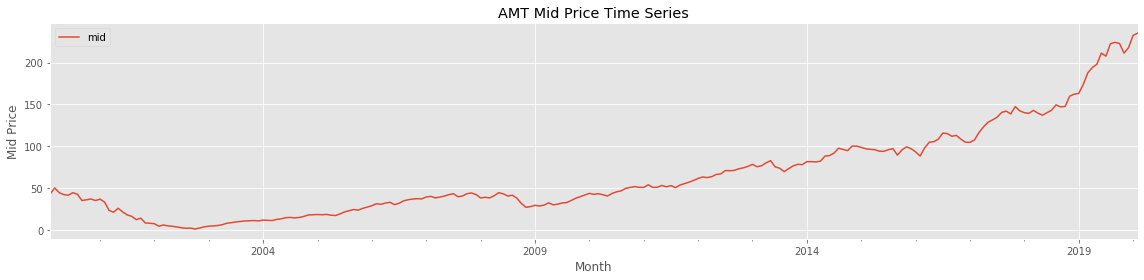

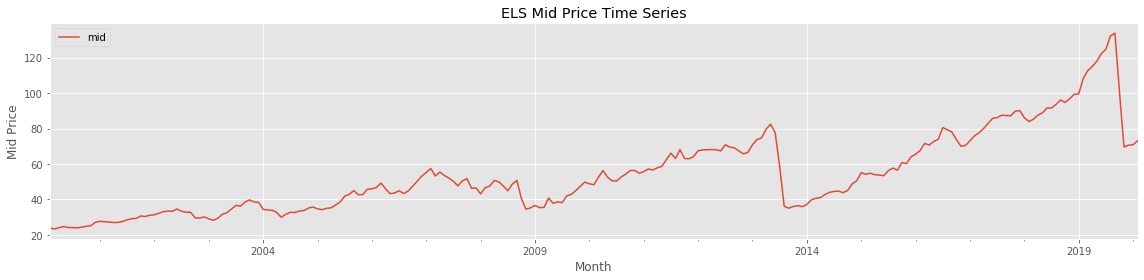

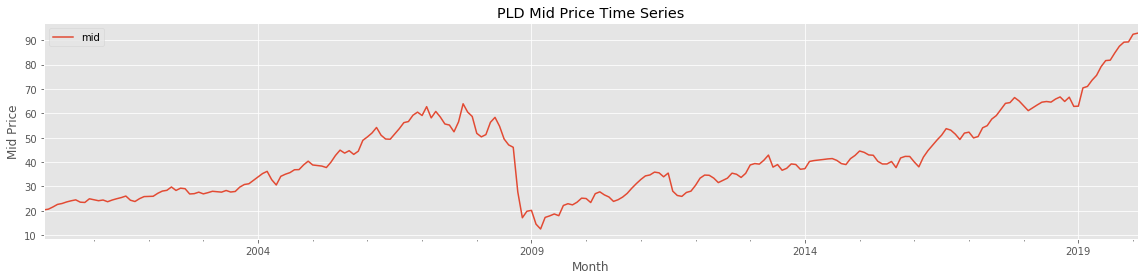

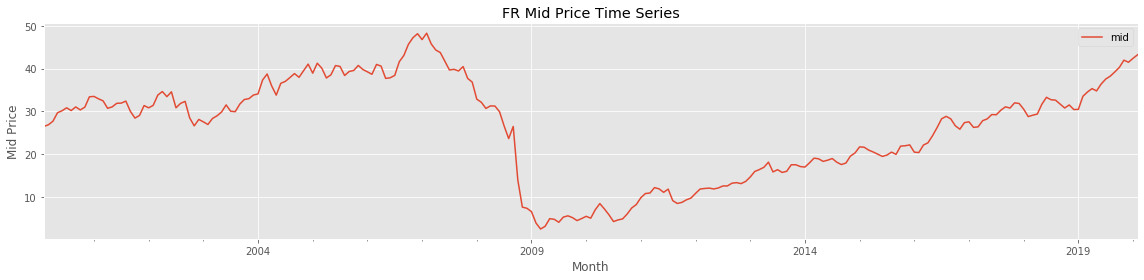

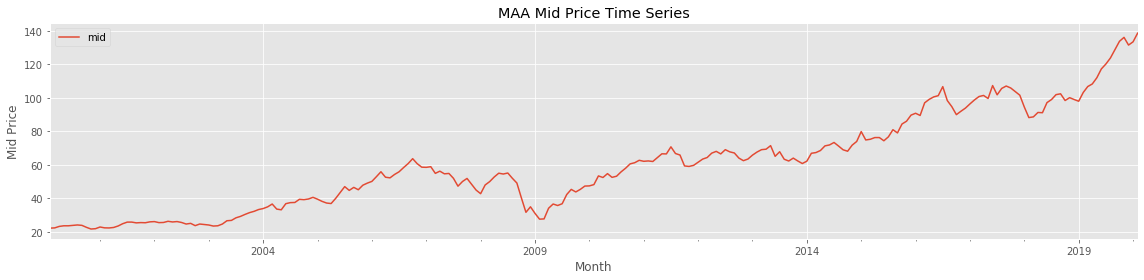

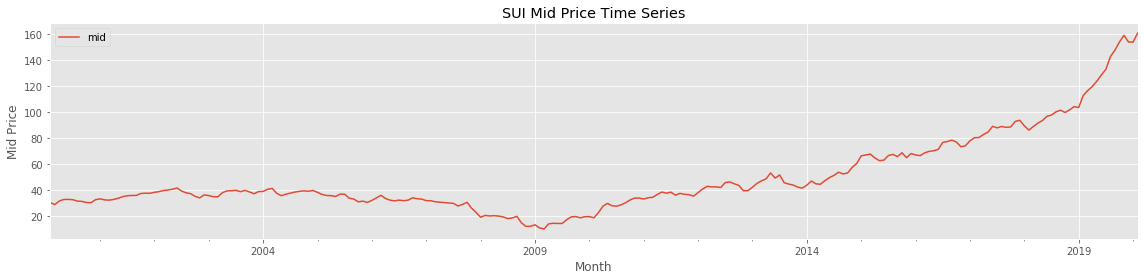

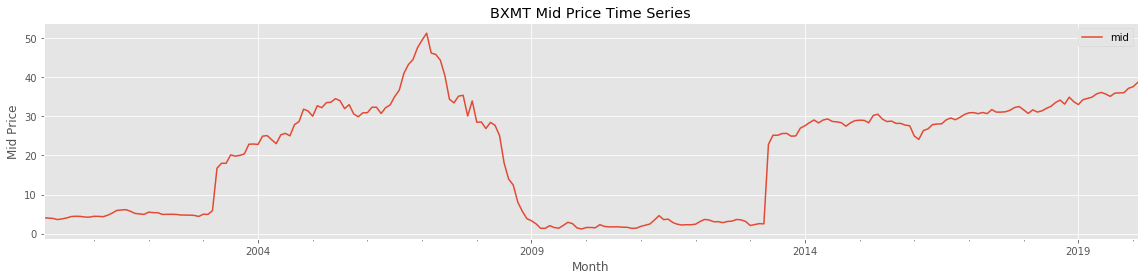

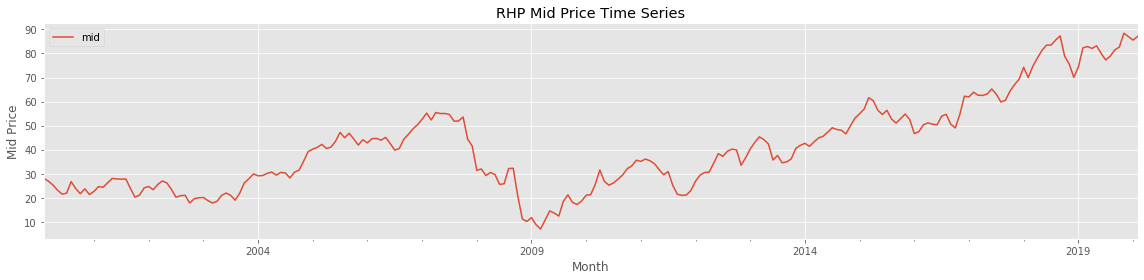

In [30]:
plot_reit_ts(reit_df_dict)

In [31]:
def decomposition(df_dict):
    for key in df_dict.keys():
        ts = df_dict[key]
        decomposition = seasonal_decompose(np.log(ts))
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        # Plot with subplots
        plt.figure(figsize=(10,6))
        plt.subplot(411)
        plt.plot(np.log(ts), label='Original', color="blue")
        plt.legend(loc='best')
        plt.title(f'{key}')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color="blue")
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color="blue")
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color="blue")
        plt.legend(loc='best')
        plt.tight_layout()
        

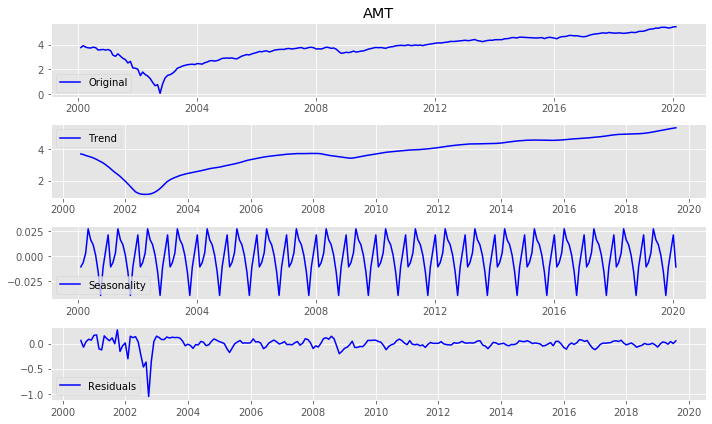

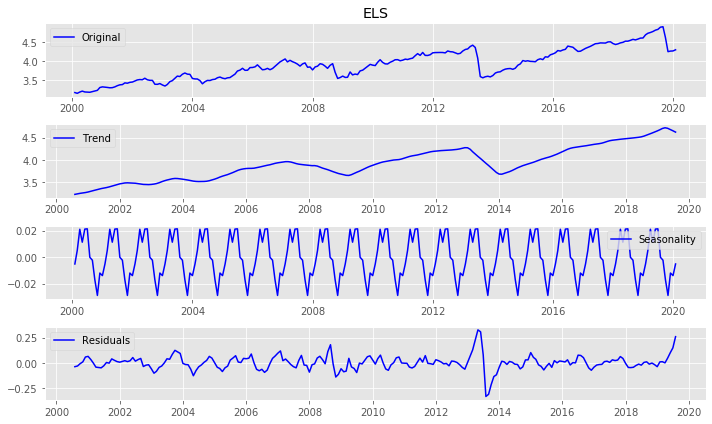

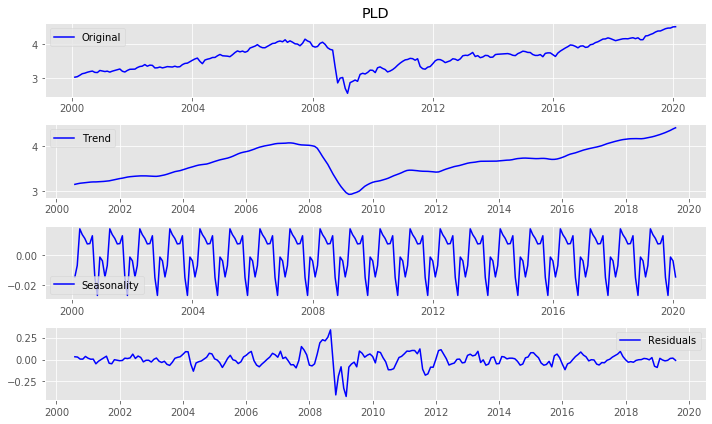

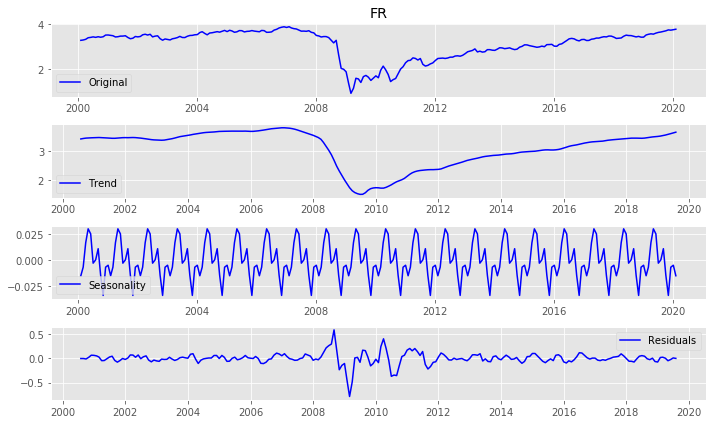

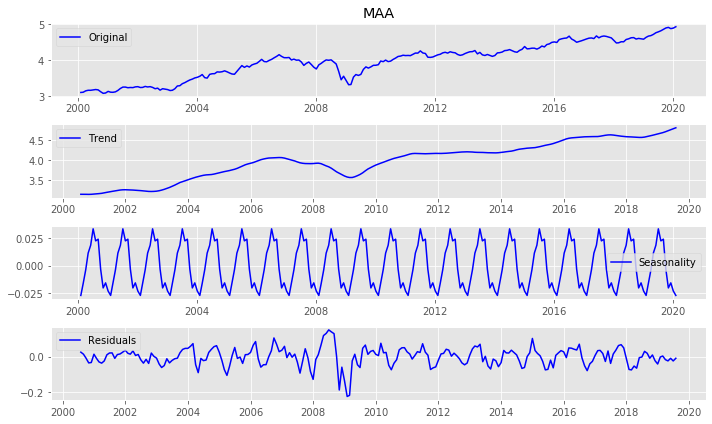

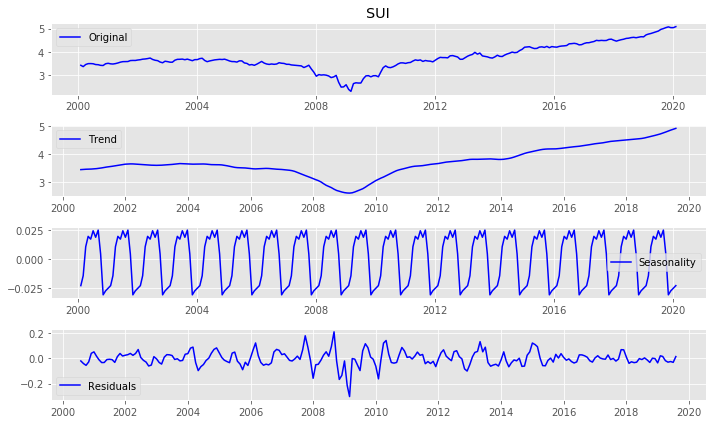

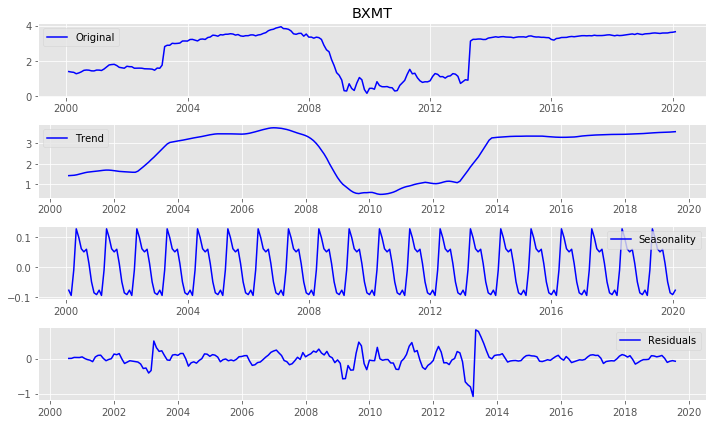

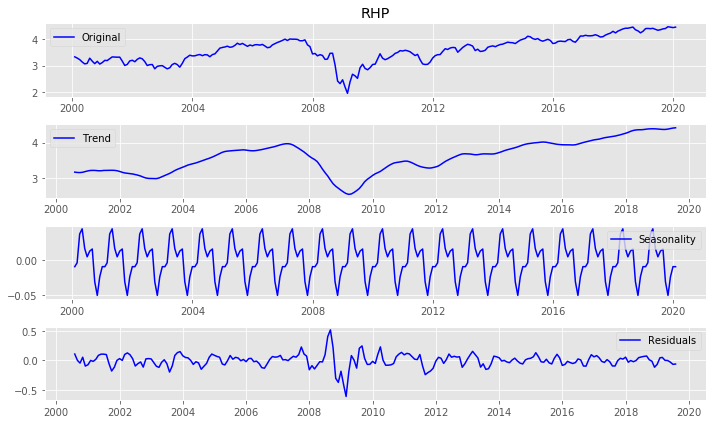

In [32]:
decomposition(reit_df_dict)

In [33]:
def differencing(df_dict):
    diff_df_dict = {}
    for key in df_dict.keys():
        diff_df_dict[key] = df_dict[key].diff(periods = 1).dropna()
        
    return diff_df_dict

In [34]:
#First order difference
diff1_reit_df_dict = differencing(reit_df_dict)

In [35]:
def dickey_fuller(df_dict):
    dftest_pvalue_dict = {}
    for key in df_dict.keys():
        dftest = adfuller(df_dict[key]['mid'])
        dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
        dftest_pvalue_dict[key] = dftest[1]
        
    print(f'{((np.array(list(dftest_pvalue_dict.values())) < 0.05).sum() / len(df_dict)) * 100} % pass Dickey Fuller Test')
    return dftest_pvalue_dict

In [36]:
dickey_fuller(diff1_reit_df_dict)

87.5 % pass Dickey Fuller Test


{'AMT': 1.3847791165235925e-05,
 'ELS': 3.1643153520549324e-19,
 'PLD': 1.466227875816387e-22,
 'FR': 0.006171744666036829,
 'MAA': 0.03411736758158935,
 'SUI': 0.4751649822658671,
 'BXMT': 8.966826027471419e-10,
 'RHP': 4.499163601727835e-20}

## ACF/PACF

In [37]:
def plot_partial_autocorrelation(df_dict):
    for key in df_dict.keys():
        plot_pacf(df_dict[key], lags = 12)
        plt.title(f'PACF - {key}')
        plt.show();

In [38]:
def plot_autocorrelation(df_dict):
    for key in df_dict.keys():
        
        plot_acf(df_dict[key], lags = 12)
        plt.title(f'ACF - {key}')
        plt.show();

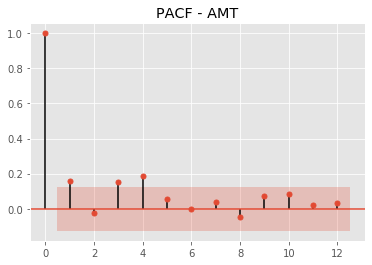

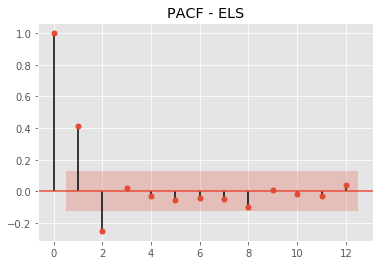

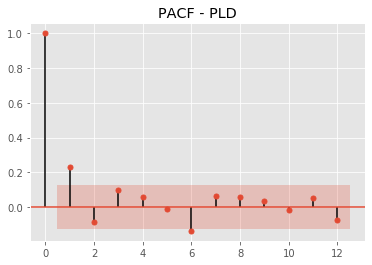

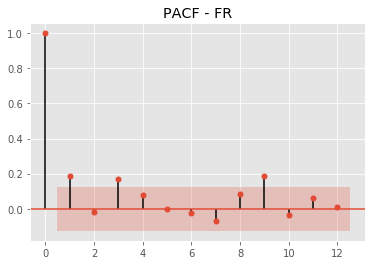

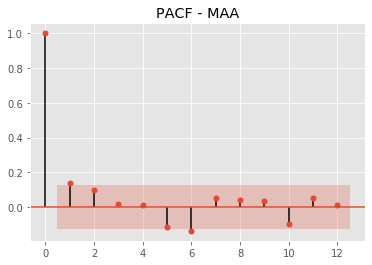

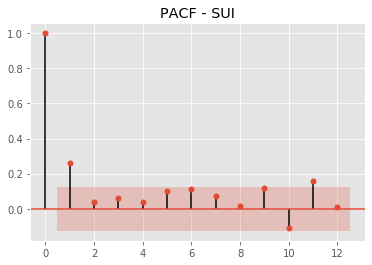

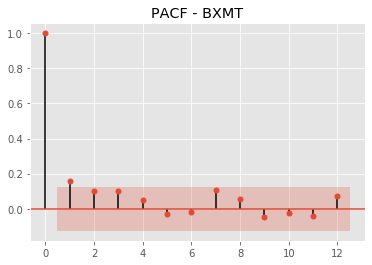

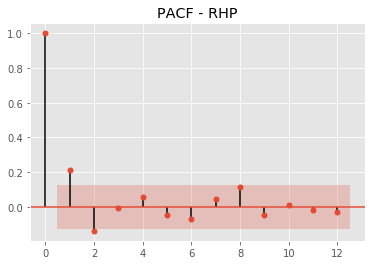

In [39]:
plot_partial_autocorrelation(diff1_reit_df_dict)

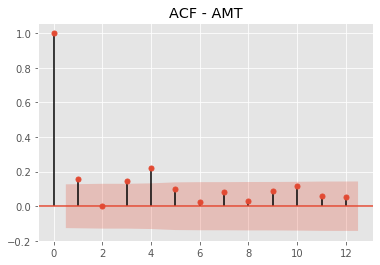

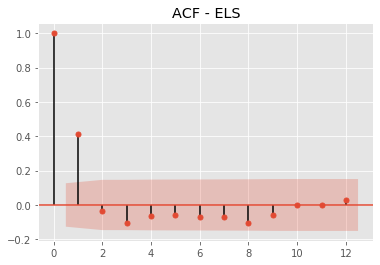

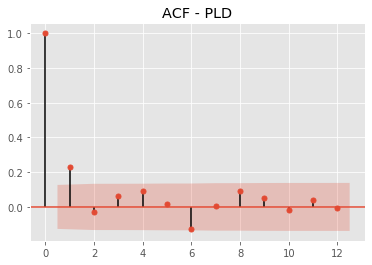

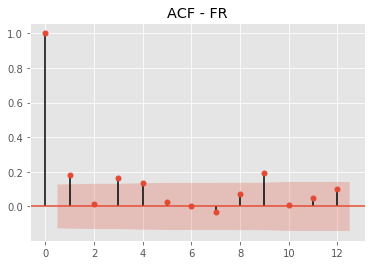

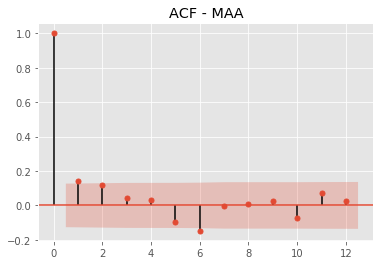

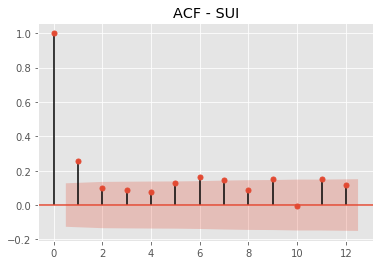

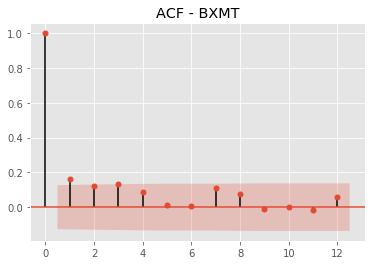

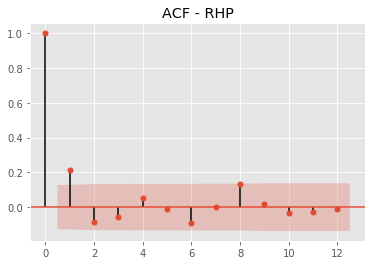

In [40]:
plot_autocorrelation(diff1_reit_df_dict)

## Parameters

In [41]:
best_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters1[key] = ()
    
best_parameters1['AMT'] = (3,1,3)
best_parameters1['ELS'] = (2,1,1)
best_parameters1['PLD'] = (2,1,1)
best_parameters1['FR'] = (3,1,3)
best_parameters1['MAA'] = (2,1,2)
best_parameters1['SUI'] = (1,1,1)
best_parameters1['BXMT'] = (1,1,1)
best_parameters1['RHP'] = (2,1,1)


In [42]:
best_seasonal_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_seasonal_parameters1['AMT'] = (3,1,3, 12)
    best_seasonal_parameters1['ELS'] = (2,1,1, 12)
    best_seasonal_parameters1['PLD'] = (2,1,0, 12)
    best_seasonal_parameters1['FR'] = (3,1,3, 12)
    best_seasonal_parameters1['MAA'] = (2,1,2, 12)
    best_seasonal_parameters1['SUI'] = (1,1,1, 12)
    best_seasonal_parameters1['BXMT'] = (1,1,1, 12)
    best_seasonal_parameters1['RHP'] = (2,1,1, 12)

## SARIMAX #1 (No Exog.)

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -512.002
Date:                            Wed, 05 Feb 2020   AIC                           1050.004
Time:                                    14:51:25   BIC                           1092.078
Sample:                                02-01-2000   HQIC                          1067.051
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5497      0.207      2.653      0.008       0.144       0.956
ar.L2         -0.5433  

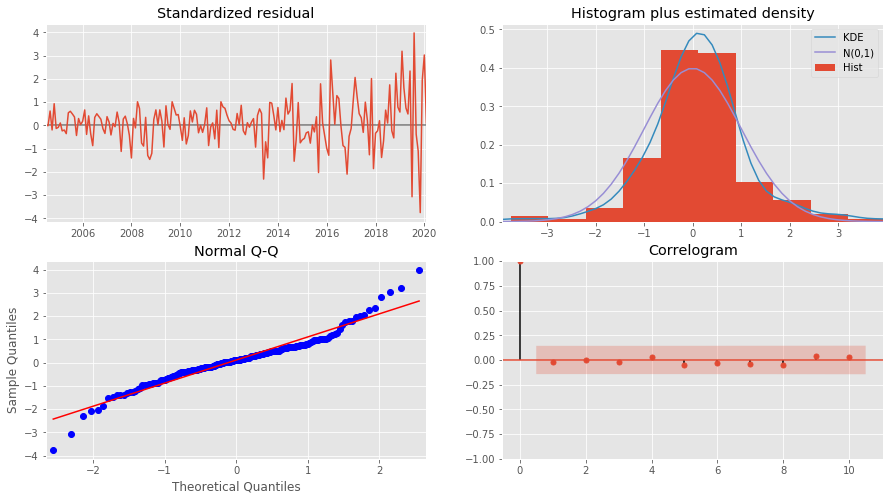

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -574.035
Date:                            Wed, 05 Feb 2020   AIC                           1162.071
Time:                                    14:51:28   BIC                           1185.228
Sample:                                02-01-2000   HQIC                          1171.440
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4504      0.263      

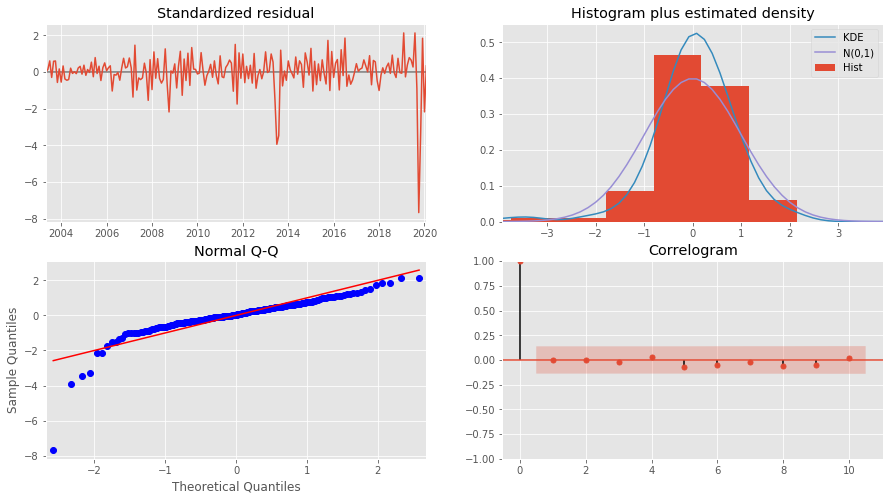

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -510.808
Date:                            Wed, 05 Feb 2020   AIC                           1033.616
Time:                                    14:51:29   BIC                           1053.466
Sample:                                02-01-2000   HQIC                          1041.647
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1699      0.504     -

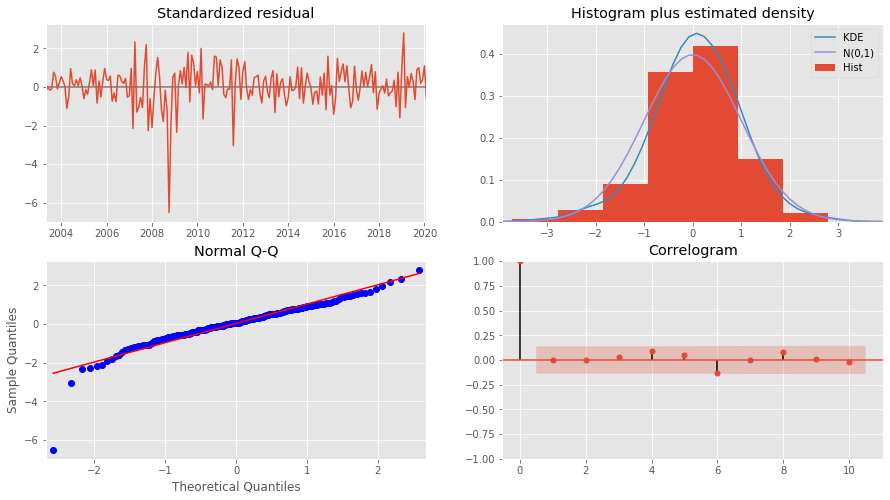

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -358.252
Date:                            Wed, 05 Feb 2020   AIC                            742.504
Time:                                    14:51:46   BIC                            784.578
Sample:                                02-01-2000   HQIC                           759.551
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8959      0.394      2

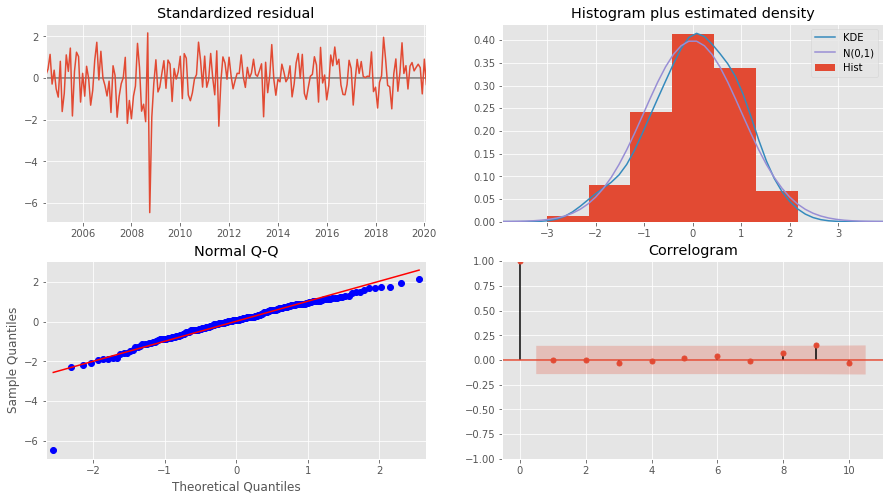

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -507.740
Date:                            Wed, 05 Feb 2020   AIC                           1033.480
Time:                                    14:51:55   BIC                           1063.210
Sample:                                02-01-2000   HQIC                          1045.510
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2270      1.479     -

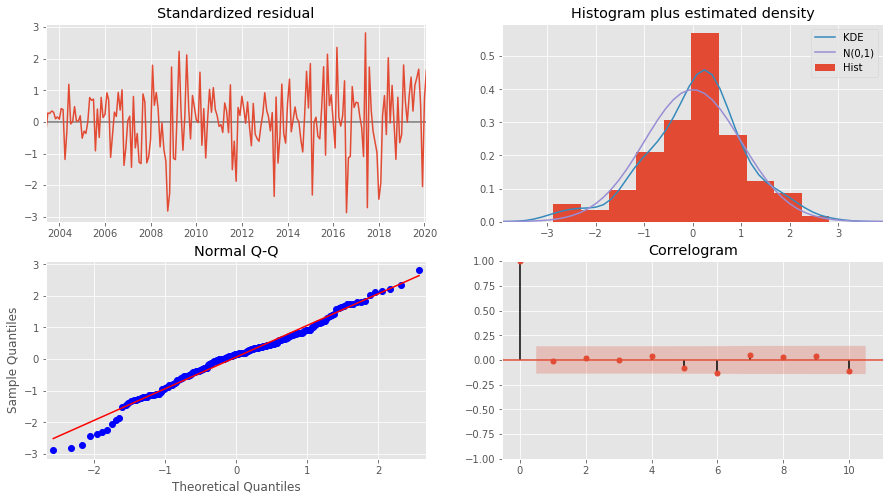

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -491.156
Date:                            Wed, 05 Feb 2020   AIC                            992.312
Time:                                    14:51:57   BIC                           1009.142
Sample:                                02-01-2000   HQIC                           999.113
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2156      0.233      

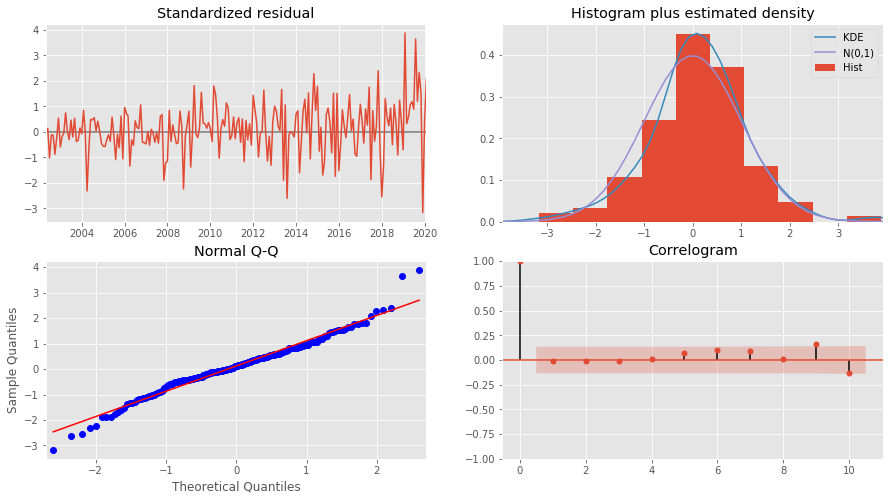

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -468.849
Date:                            Wed, 05 Feb 2020   AIC                            947.697
Time:                                    14:52:00   BIC                            964.527
Sample:                                02-01-2000   HQIC                           954.498
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7999      0.159     

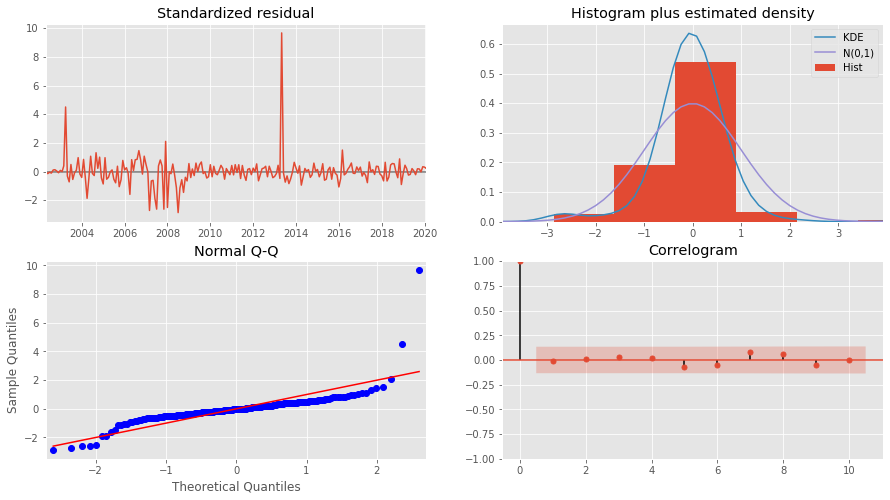

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -517.381
Date:                            Wed, 05 Feb 2020   AIC                           1048.763
Time:                                    14:52:07   BIC                           1071.921
Sample:                                02-01-2000   HQIC                          1058.133
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3082      0.515      

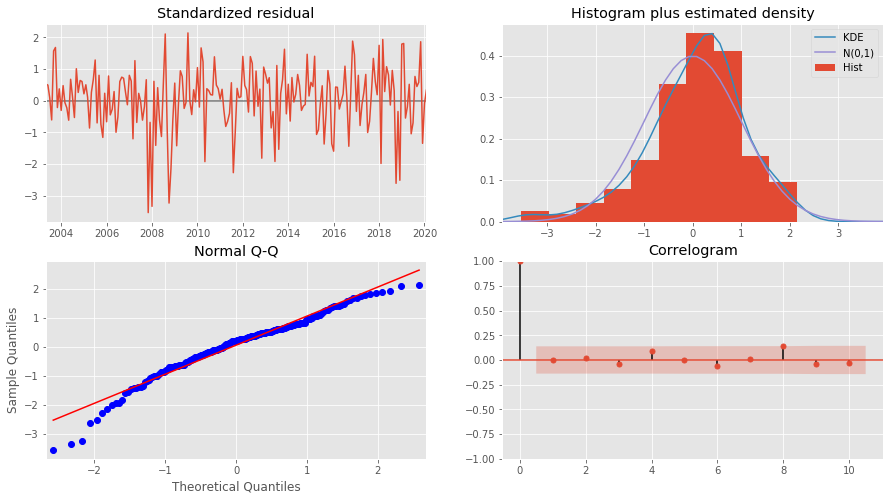

---------------------------------------------------------------


In [43]:
warnings.filterwarnings('ignore')
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters1[key],
                                            seasonal_order = best_seasonal_parameters1[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False)
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

## SARIMAX #2 (No Exog)

In [44]:
best_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters2[key] = ()
    
best_parameters2['AMT'] = (3,1,2)
best_parameters2['ELS'] = (1,1,1)
best_parameters2['PLD'] = (1,1,2)
best_parameters2['FR'] = (3,1,2)
best_parameters2['MAA'] = (3,1,2)
best_parameters2['SUI'] = (3,1,3)
best_parameters2['BXMT'] = (2,1,2)
best_parameters2['RHP'] = (3,1,2)

In [45]:
best_seasonal_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_seasonal_parameters2[key] = ()
    
best_seasonal_parameters2['AMT'] = (3,1,2, 12)
best_seasonal_parameters2['ELS'] = (1,1,1, 12)
best_seasonal_parameters2['PLD'] = (1,1,2, 12)
best_seasonal_parameters2['FR'] = (3,1,2, 12)
best_seasonal_parameters2['MAA'] = (3,1,2, 12)
best_seasonal_parameters2['SUI'] = (3,1,3, 12)
best_seasonal_parameters2['BXMT'] = (2,1,2, 12)
best_seasonal_parameters2['RHP'] = (3,1,2, 12)

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -513.802
Date:                            Wed, 05 Feb 2020   AIC                           1051.605
Time:                                    14:52:21   BIC                           1090.506
Sample:                                02-01-2000   HQIC                          1067.364
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0037      0.003      1.108      0.268      -0.003       0.010
ar.L1          0.4737  

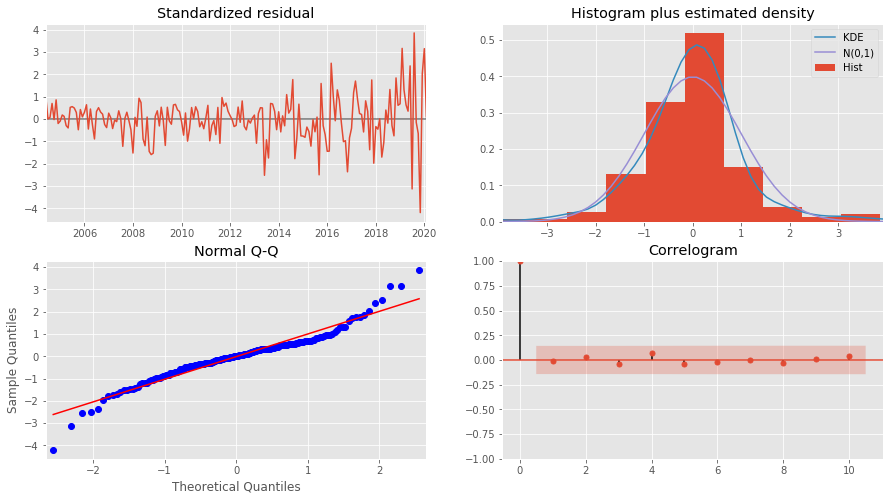

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -602.035
Date:                            Wed, 05 Feb 2020   AIC                           1216.069
Time:                                    14:52:24   BIC                           1236.265
Sample:                                02-01-2000   HQIC                          1224.230
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002      0.001     -

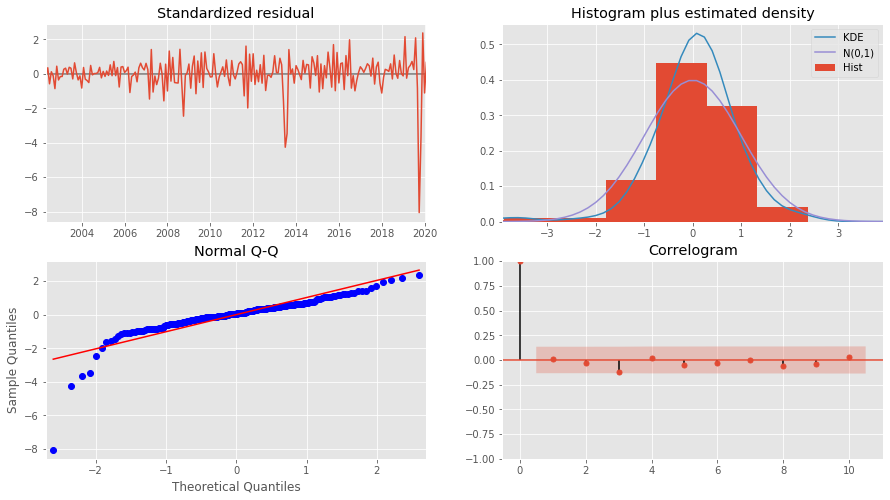

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -485.977
Date:                            Wed, 05 Feb 2020   AIC                            987.953
Time:                                    14:52:31   BIC                           1014.380
Sample:                                02-01-2000   HQIC                           998.647
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0004      0.001      

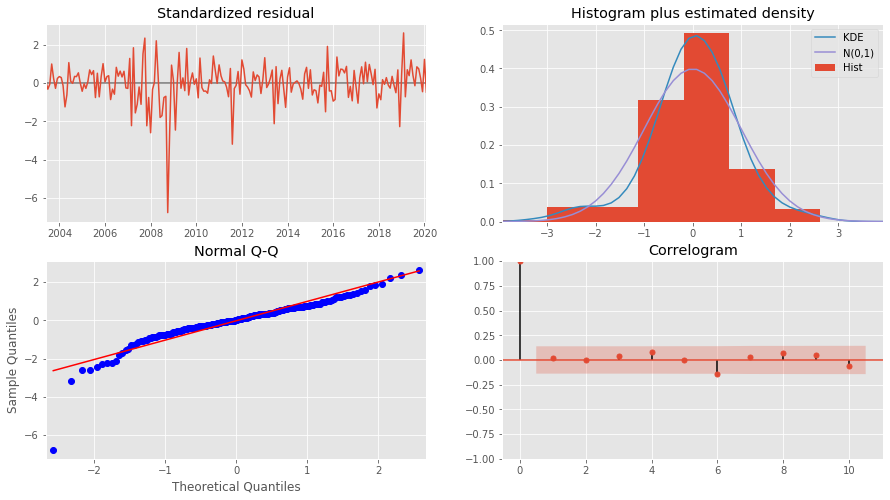

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -363.091
Date:                            Wed, 05 Feb 2020   AIC                            750.182
Time:                                    14:52:47   BIC                            789.083
Sample:                                02-01-2000   HQIC                           765.942
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0004      0.000      0

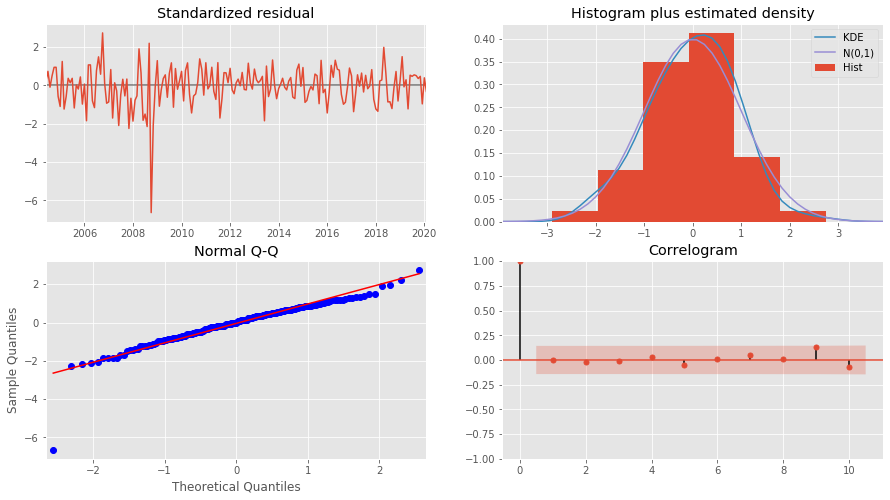

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -481.583
Date:                            Wed, 05 Feb 2020   AIC                            987.165
Time:                                    14:53:02   BIC                           1026.066
Sample:                                02-01-2000   HQIC                          1002.925
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0021      0.002      

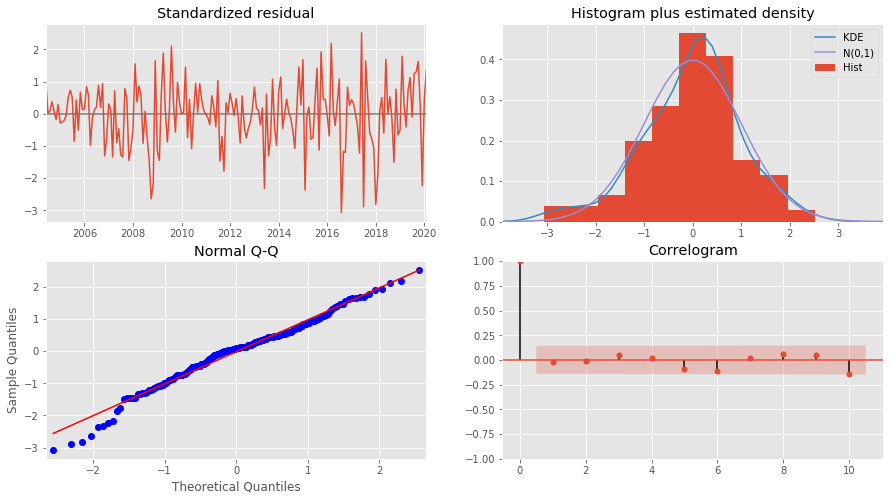

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -430.370
Date:                            Wed, 05 Feb 2020   AIC                            888.741
Time:                                    14:53:21   BIC                            934.051
Sample:                                02-01-2000   HQIC                           907.099
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0045      0.006      

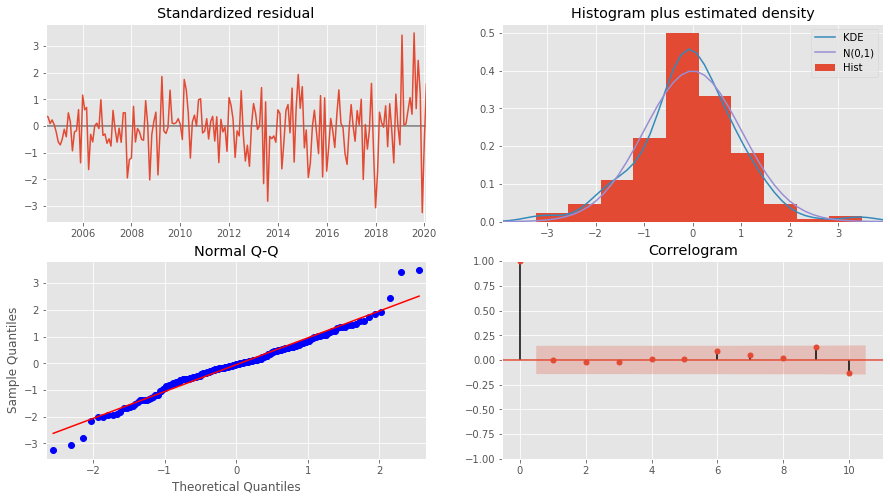

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -453.614
Date:                            Wed, 05 Feb 2020   AIC                            927.228
Time:                                    14:53:29   BIC                            960.261
Sample:                                02-01-2000   HQIC                           940.595
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       6.843e-06      0.000     

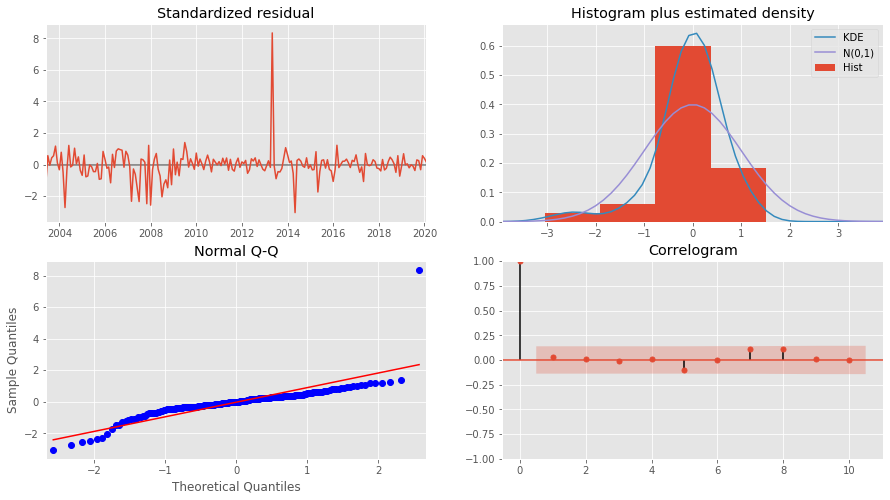

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -486.501
Date:                            Wed, 05 Feb 2020   AIC                            997.001
Time:                                    14:53:43   BIC                           1035.902
Sample:                                02-01-2000   HQIC                          1012.761
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0007      0.001      

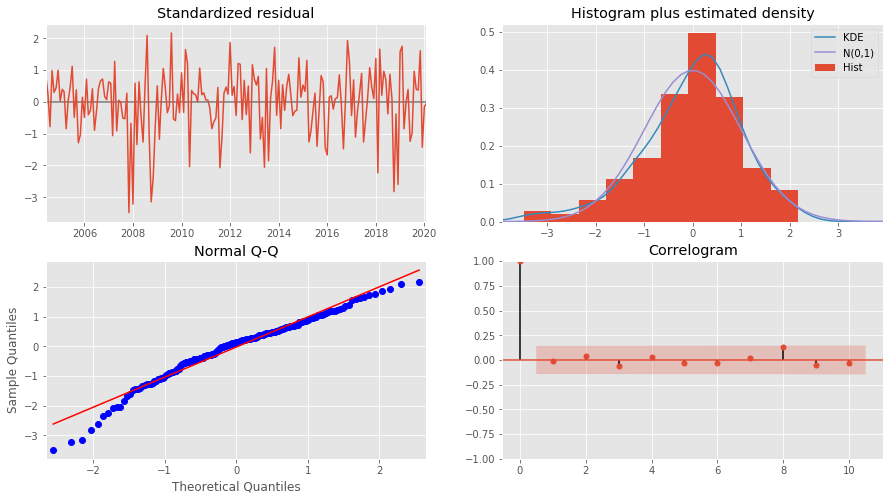

---------------------------------------------------------------


In [46]:
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters2[key],
                                            seasonal_order = best_seasonal_parameters2[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

## SARIMAX #1 + Exog

In [47]:
fred = Fred(api_key = 'aec5f13aa40d1af4edd587ffccceeb1a')
libor = fred.get_series('USD1MTD156N', start, end)
libor_monthly = round(libor.resample('MS').mean(),2)
libor_monthly = pd.DataFrame(libor_monthly, index = libor_monthly.index, columns = ['rate'])

In [48]:
libor_train = libor_monthly[:'2015']
libor_test = libor_monthly['2016':]

In [49]:
train_reit_df_dict = {}
test_reit_df_dict = {}
for key in reit_df_dict.keys():
    train = reit_df_dict[key][:'2015']
    test = reit_df_dict[key]['2016':]
    train_reit_df_dict[key] = train
    test_reit_df_dict[key] = test

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -315.979
Date:                            Wed, 05 Feb 2020   AIC                            661.958
Time:                                    15:25:22   BIC                            705.867
Sample:                                02-01-2000   HQIC                           679.802
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.444      0.657      -0.001       0.002
rate           0.2126  

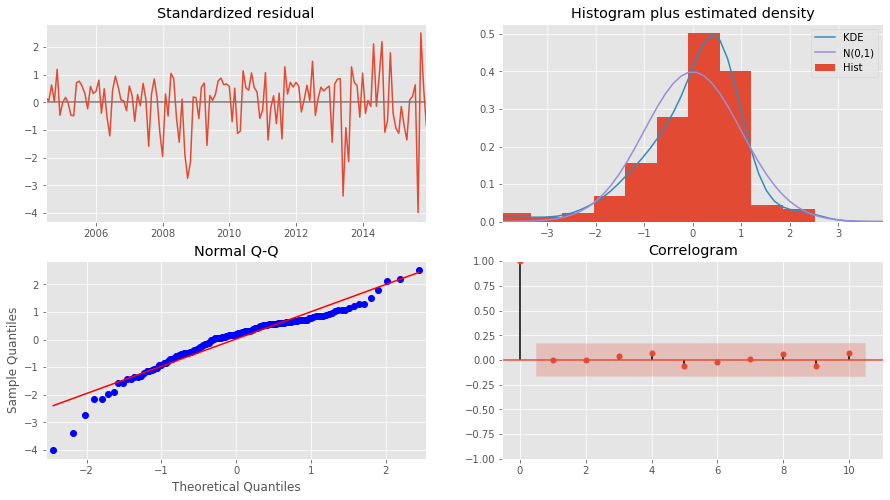

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -398.823
Date:                            Wed, 05 Feb 2020   AIC                            815.646
Time:                                    15:25:28   BIC                            842.861
Sample:                                02-01-2000   HQIC                           826.702
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -5.294e-05      0.001     -

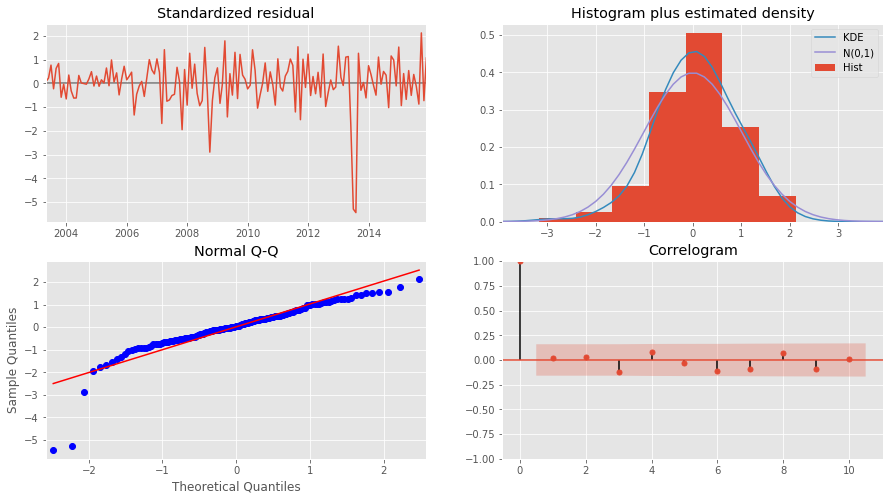

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -390.546
Date:                            Wed, 05 Feb 2020   AIC                            797.092
Time:                                    15:25:34   BIC                            821.283
Sample:                                02-01-2000   HQIC                           806.919
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.486e-05      0.003      

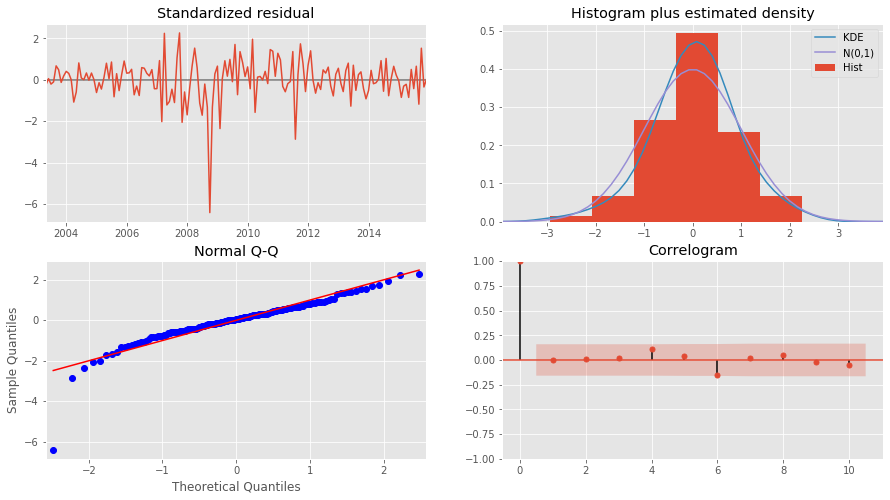

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -274.925
Date:                            Wed, 05 Feb 2020   AIC                            579.851
Time:                                    15:25:52   BIC                            623.760
Sample:                                02-01-2000   HQIC                           597.694
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0

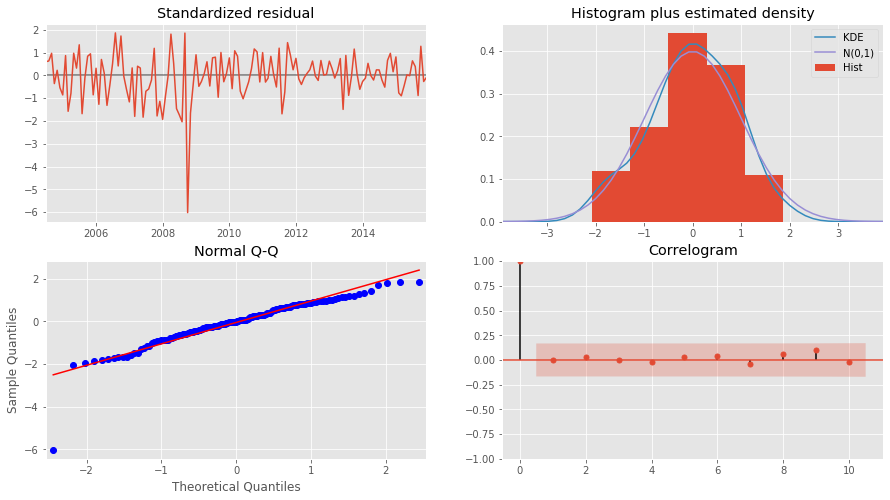

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -365.453
Date:                            Wed, 05 Feb 2020   AIC                            752.905
Time:                                    15:25:59   BIC                            786.095
Sample:                                02-01-2000   HQIC                           766.389
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0011      0.001      

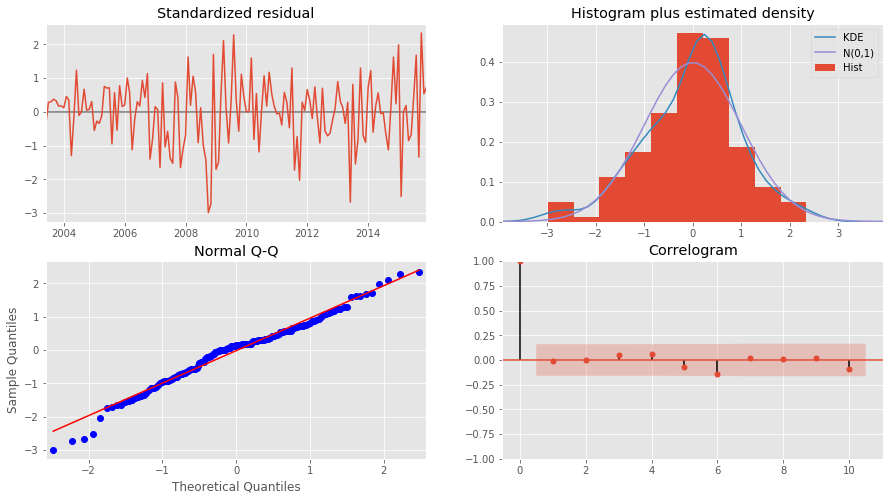

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -352.611
Date:                            Wed, 05 Feb 2020   AIC                            719.222
Time:                                    15:26:02   BIC                            740.921
Sample:                                02-01-2000   HQIC                           728.031
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0007      0.001      

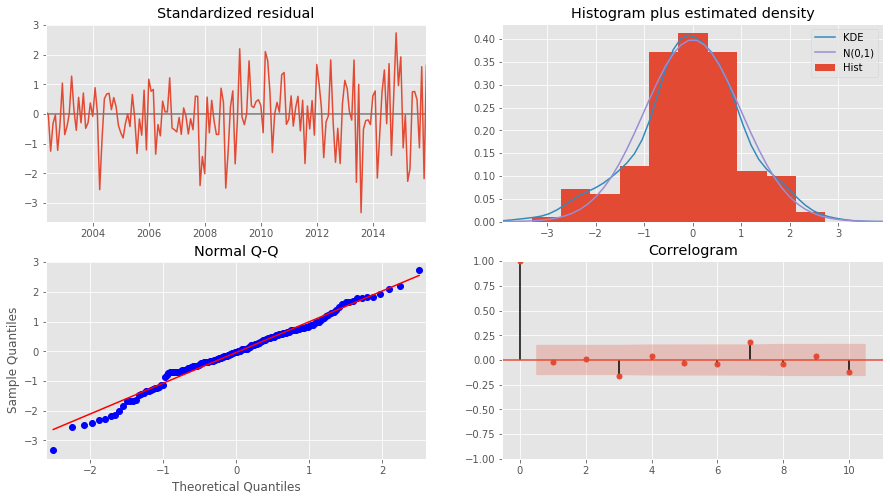

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -382.484
Date:                            Wed, 05 Feb 2020   AIC                            778.967
Time:                                    15:26:04   BIC                            800.666
Sample:                                02-01-2000   HQIC                           787.776
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       8.633e-05      0.000     

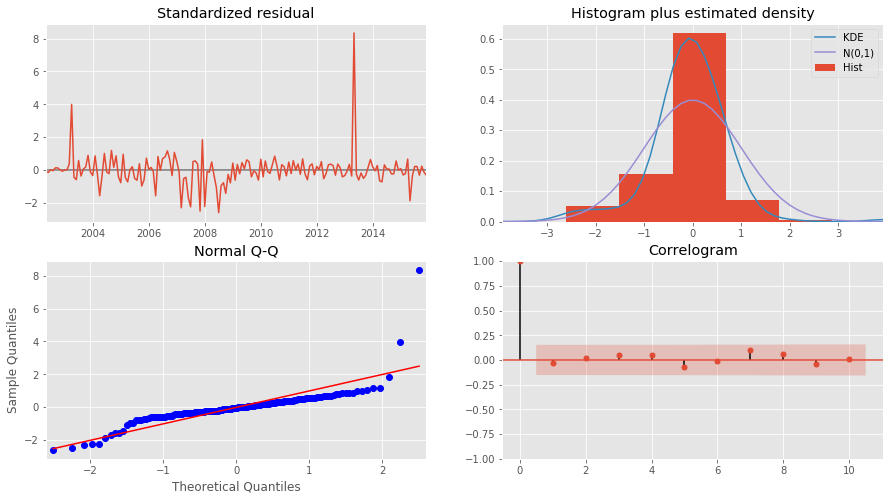

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -386.635
Date:                            Wed, 05 Feb 2020   AIC                            791.269
Time:                                    15:26:11   BIC                            818.484
Sample:                                02-01-2000   HQIC                           802.325
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.001      

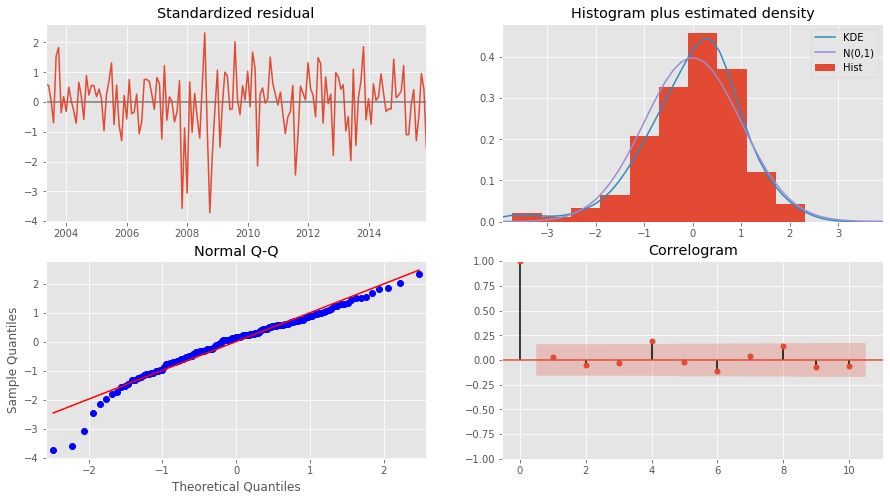

---------------------------------------------------------------


In [65]:
results_dict1 = {}
for key in train_reit_df_dict.keys():
    ts = train_reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                                            exog = libor_train,
                                            order = best_parameters1[key],
                                            seasonal_order = best_seasonal_parameters1[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict1[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

## SARIMA #2 + Exog

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -317.788
Date:                            Wed, 05 Feb 2020   AIC                            661.576
Time:                                    15:26:44   BIC                            699.725
Sample:                                02-01-2000   HQIC                           677.079
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.379      0.705      -0.001       0.002
rate           0.2185  

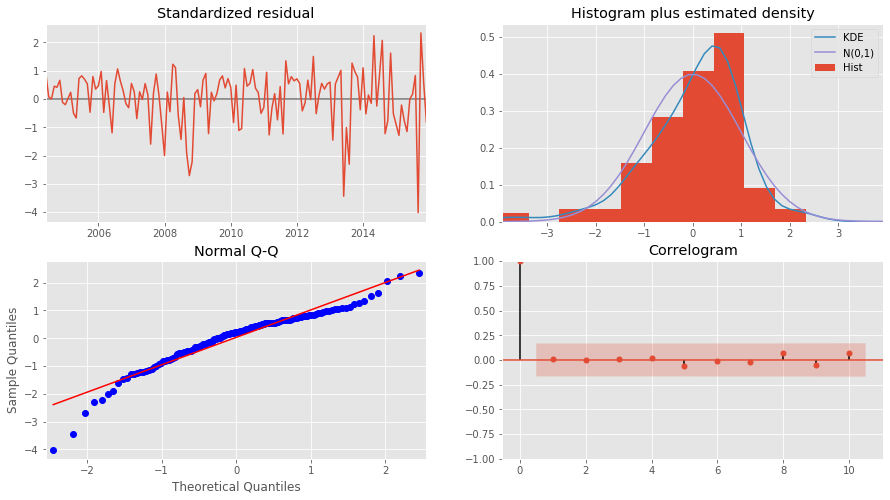

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -423.461
Date:                            Wed, 05 Feb 2020   AIC                            860.921
Time:                                    15:26:48   BIC                            882.620
Sample:                                02-01-2000   HQIC                           869.730
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        1.68e-05      0.001      

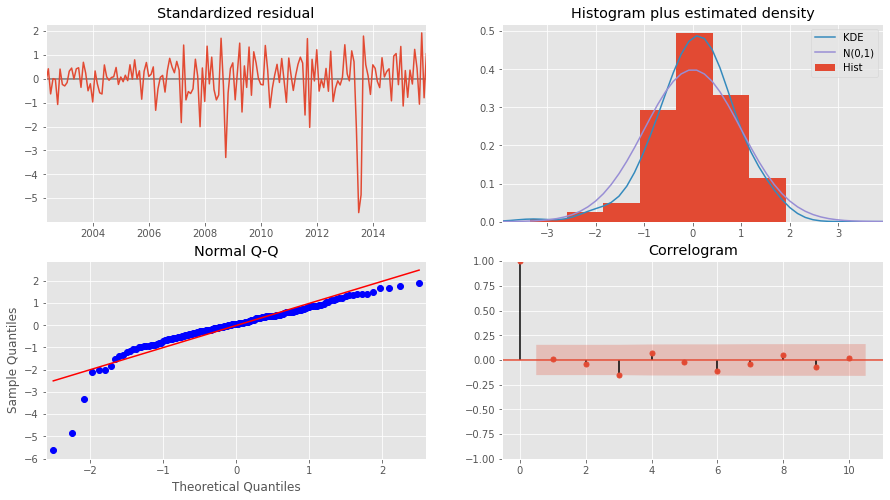

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -373.849
Date:                            Wed, 05 Feb 2020   AIC                            765.697
Time:                                    15:26:53   BIC                            792.853
Sample:                                02-01-2000   HQIC                           776.729
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002      0.001     -

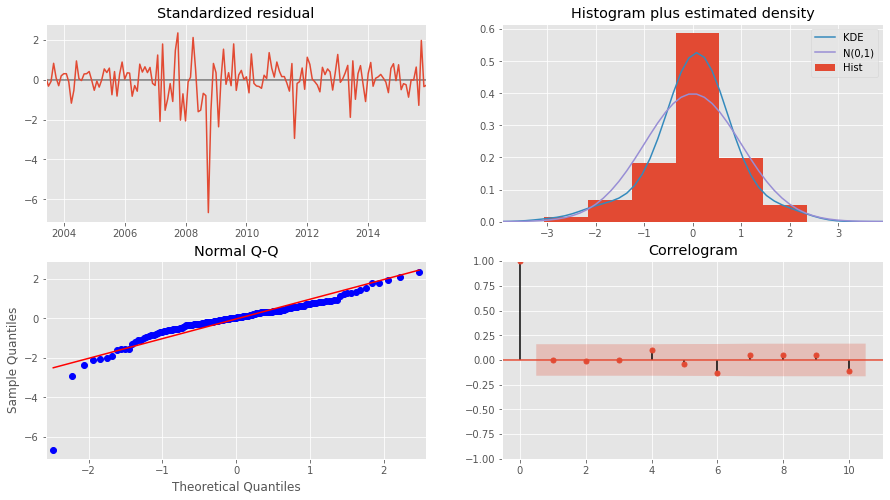

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -282.586
Date:                            Wed, 05 Feb 2020   AIC                            591.173
Time:                                    15:27:06   BIC                            629.321
Sample:                                02-01-2000   HQIC                           606.675
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       7.412e-05      0.000      0

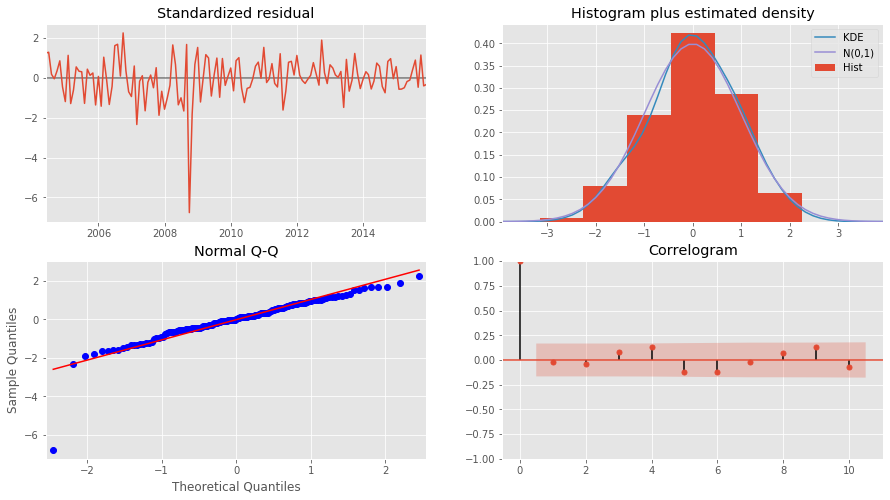

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -339.839
Date:                            Wed, 05 Feb 2020   AIC                            705.677
Time:                                    15:27:18   BIC                            743.825
Sample:                                02-01-2000   HQIC                           721.180
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0011      0.002      

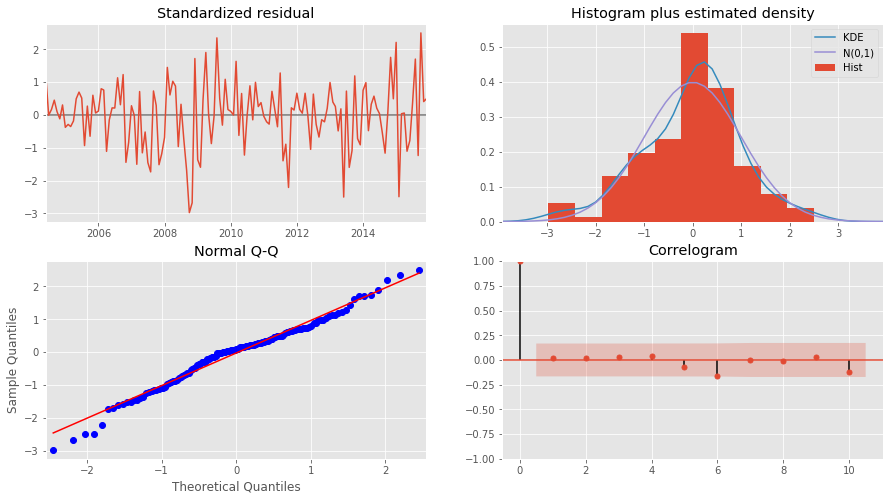

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -294.732
Date:                            Wed, 05 Feb 2020   AIC                            619.465
Time:                                    15:27:35   BIC                            663.373
Sample:                                02-01-2000   HQIC                           637.308
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0021      0.005      

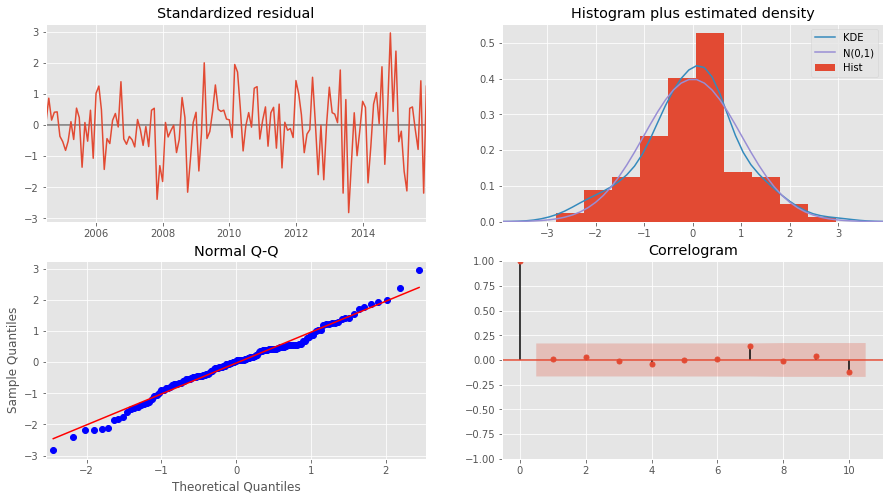

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -363.125
Date:                            Wed, 05 Feb 2020   AIC                            748.250
Time:                                    15:27:43   BIC                            781.440
Sample:                                02-01-2000   HQIC                           761.733
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0006      0.001     

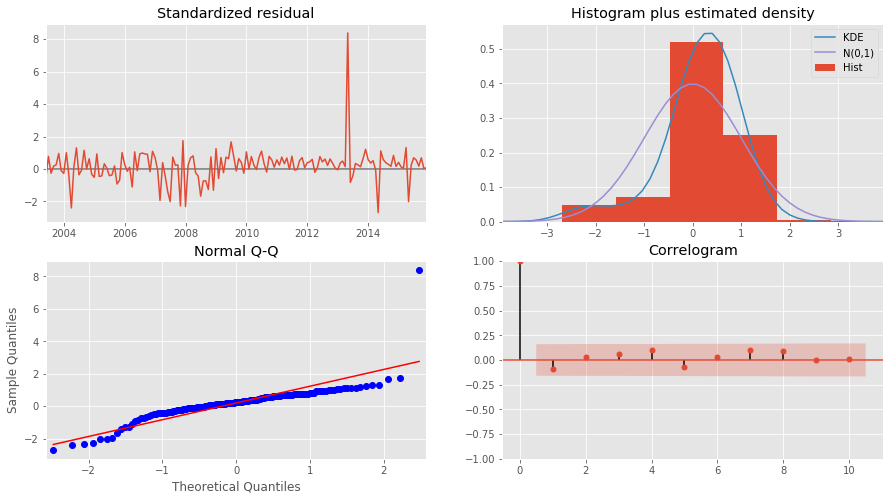

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -348.665
Date:                            Wed, 05 Feb 2020   AIC                            723.329
Time:                                    15:27:55   BIC                            761.478
Sample:                                02-01-2000   HQIC                           738.832
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0007      0.002      

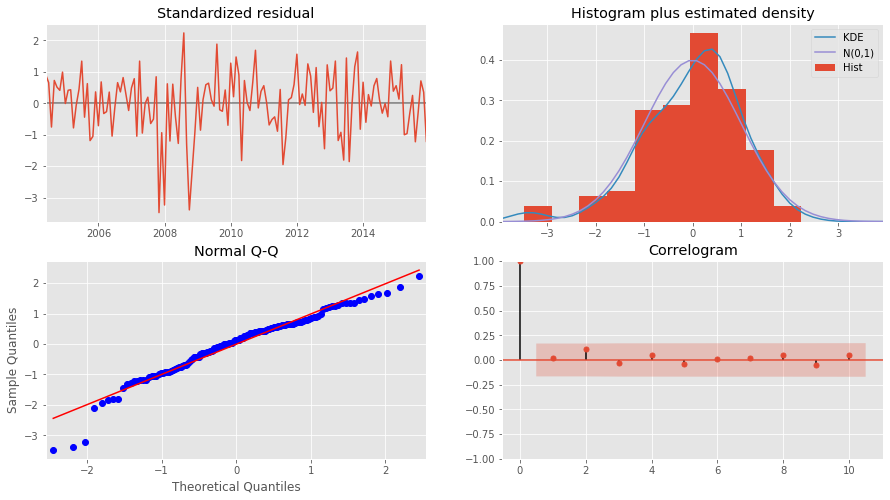

---------------------------------------------------------------


In [68]:
results_dict2 = {}
for key in train_reit_df_dict.keys():
    ts = train_reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                                            exog = libor_train,
                                            order = best_parameters2[key],
                                            seasonal_order = best_seasonal_parameters2[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict2[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

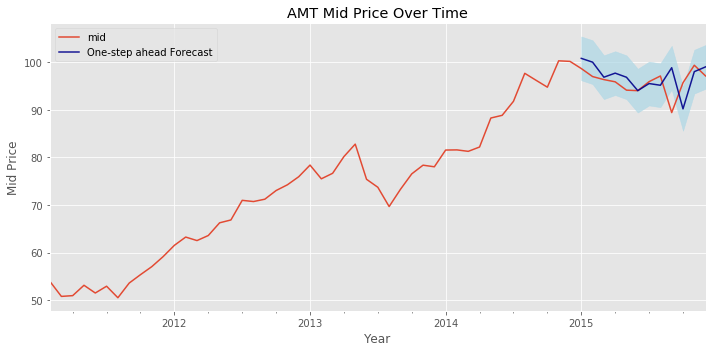

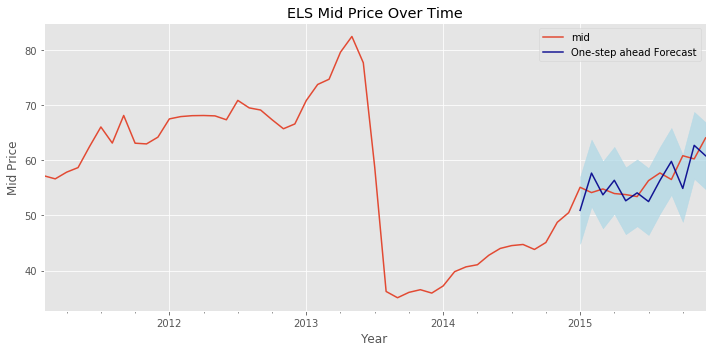

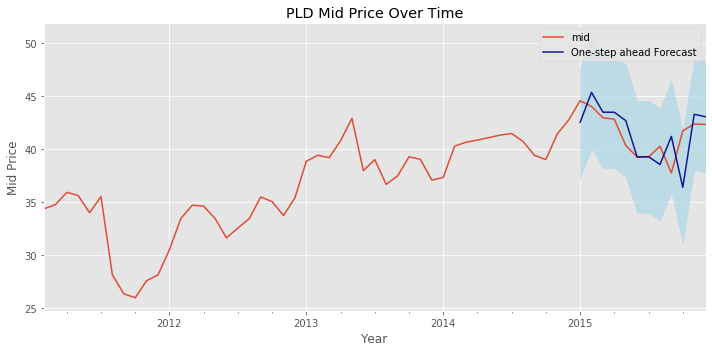

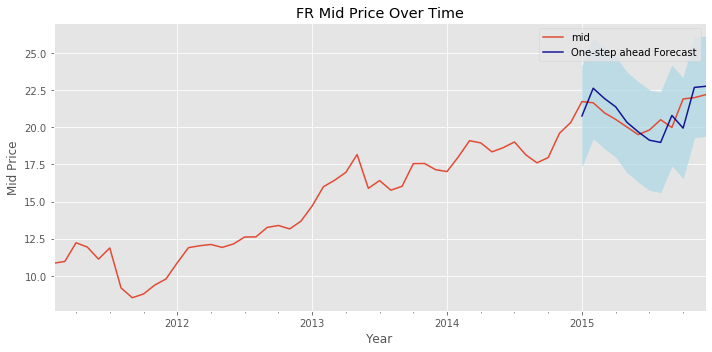

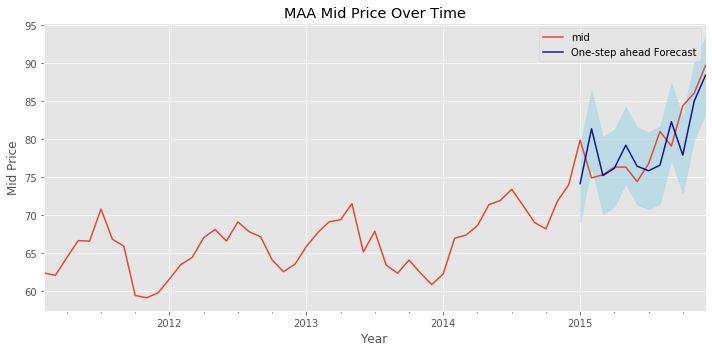

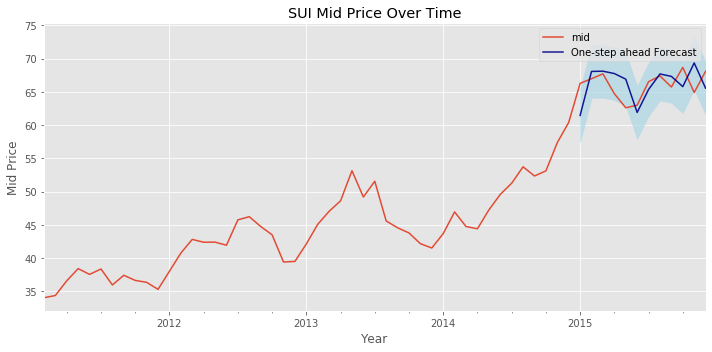

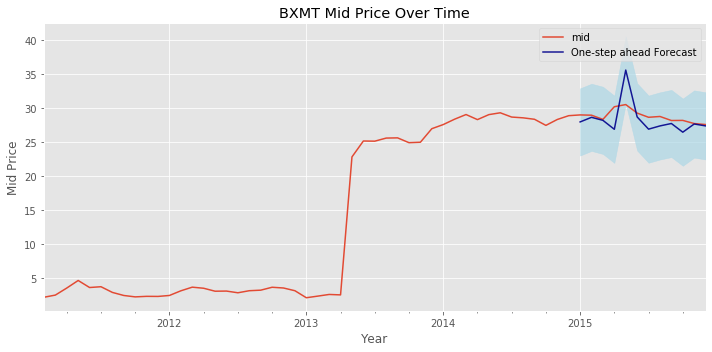

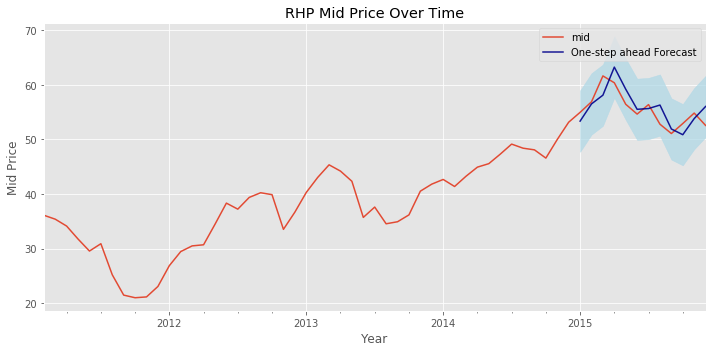

In [127]:
# Get predictions starting from 2000 and calculate confidence intervals.
# Compare predictions to actual data 2000-2014
for key in results_dict2.keys():
    results = results_dict2[key]
    predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic=False, exog = libor_train)
    pred_conf = predictions.conf_int()
    
    #Plot observed values
    ax = train_reit_df_dict[key]['2011-02-01':].plot(label='observed', figsize = (10,5))

    #Plot predicted values
    predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue')

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

    #Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Mid Price')
    plt.legend(loc = 'best')
    plt.title(f'{key} Mid Price Over Time')
    plt.tight_layout()
    plt.show()
    

## Final SARIMAX(w/Exogenous LIBOR)

In [138]:
final_parameters = {}
for key in diff1_reit_df_dict.keys():
    final_parameters[key] = ()
    
best_parameters2['AMT'] = (3,1,2)
best_parameters2['ELS'] = (2,1,1)
best_parameters2['PLD'] = (1,1,2)
best_parameters2['FR'] = (3,1,3)
best_parameters2['MAA'] = (3,1,2)
best_parameters2['SUI'] = (3,1,3)
best_parameters2['BXMT'] = (1,1,1)
best_parameters2['RHP'] = (3,1,2)

In [142]:
final_seasonal_parameters = {}
for key in diff1_reit_df_dict.keys():
    final_seasonal_parameters[key] = ()
    
final_seasonal_parameters['AMT'] = (3,1,2,12)
final_seasonal_parameters['ELS'] = (2,1,1,12)
final_seasonal_parameters['PLD'] = (1,1,2,12)
final_seasonal_parameters['FR'] = (3,1,3,12)
final_seasonal_parameters['MAA'] = (3,1,2,12)
final_seasonal_parameters['SUI'] = (3,1,3,12)
final_seasonal_parameters['BXMT'] = (1,1,1,12)
final_seasonal_parameters['RHP'] = (3,1,2,12)

In [143]:
final_results_dict = {}
for key in train_reit_df_dict.keys():
    ts = train_reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                                            exog = libor_train,
                                            order = final_parameters[key],
                                            seasonal_order = final_seasonal_parameters[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    final_results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

IndexError: tuple index out of range

## Auto-ARIMA:

AMT
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 12, 0, 12); AIC=789.418, BIC=794.904, Fit time=104.409 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 12, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 12, 1, 12); AIC=771.666, BIC=780.809, Fit time=273.711 seconds
Near non-invertible roots for order (0, 1, 1)(0, 12, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 12, 0, 12); AIC=1123.866, BIC=1131.181, Fit time=121.258 seconds
Near non-invertible roots for order (0, 1, 0)(1, 12, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 12, 1, 12); AIC=769.145, BIC=776.460, Fit time=236.731 seconds
Near non-invertible roots for order (0, 1, 0)(0, 12, 1, 12); setting score to inf (at least one inverse root too close to the border of the u

ValueError: When an ARIMA is fit with an exogenous array, it must also be provided one for predicting or updating observations.

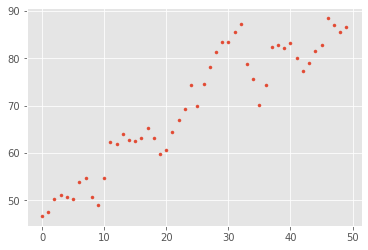

In [395]:

for key in train_reit_df_dict.keys():
    print(key)
    ts = train_reit_df_dict[key]
    auto_arima = auto_arima = pm.auto_arima(ts, 
                      exogenous = libor_train,
                      error_action='ignore', trace=True,
                      suppress_warnings=True, d =1,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      start_P=0, start_Q=0,
                      stationary=False,
                      with_intercept=False, 
                      D = 12, trend = 't')
    
    x = np.arange(test.shape[0])
    plt.scatter(x, test, marker = '.')
    plt.plot(x, auto_arima.predict(n_periods = test.shape[0]))
    plt.title(f'Actual {key} - Test Samples vs. Forecasts')
    plt.show()